(https://stackabuse.com/text-classification-with-python-and-scikit-learn/)

In [ ]:
%reset

# Imports

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import string
pd.options.mode.chained_assignment = None  # default='warn'
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
from time import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

# Data recovery

In [3]:
dataset = pd.read_csv("H:/Documents/Cours/ING3/NLP/TD4/simpsons_dataset.csv")
dataset = dataset.dropna().reset_index(drop = True)

In [4]:
dataset.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


# Selection of the characters with the most lines
(more than 1000)

In [5]:
group = dataset.groupby('raw_character_text').count().reset_index()
perso_principaux = group[group["spoken_words"]>1000].reset_index()
perso_list = perso_principaux.raw_character_text.tolist()
dataset = dataset.drop(dataset[~dataset.raw_character_text.isin(perso_list)].index).reset_index(drop = True)
dataset.head(5)

,raw_character_text,spoken_words
0,Lisa Simpson,Where's Mr. Bergstrom?
1,Lisa Simpson,That life is worth living.
2,Bart Simpson,Victory party under the slide!
3,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!
4,Lisa Simpson,Do you know where I could find him?


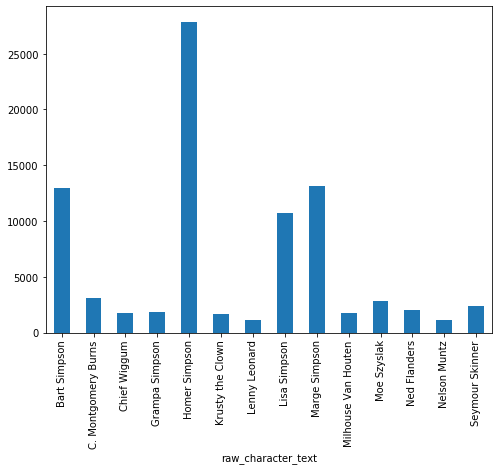

In [6]:
fig = plt.figure(figsize=(8,6))
dataset.groupby('raw_character_text').spoken_words.count().plot.bar(ylim=0)
plt.show()

In [7]:
stopwords = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def processSentence(sentence, remove_stopwords):
    ww = sentence.split()
    #ww = nltk.word_tokenize(sentence)
    if remove_stopwords == 1:
        ww = [x for x in ww if x not in stopwords]
    ww = [x for x in ww if x !=""]
    ww = [lemmatizer.lemmatize(x) for x in ww]
    if len(ww)>2:
        return " ".join(ww)
    else:
        return np.nan

def preprocessing(dataset, remove_stopwords = 1):
    datatemp = dataset.copy()
    ### Removes non-alphabetic characters:
    datatemp.spoken_words = [re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in datatemp['spoken_words']]
    datatemp.spoken_words= [re.sub("[/']", '', str(row)).lower() for row in datatemp.spoken_words]
    
    cleaned = [processSentence(x, remove_stopwords) for x in datatemp.spoken_words.tolist()]

    datasetCleaned = datatemp.copy()
    datasetCleaned.spoken_words = cleaned
    datasetCleaned = datasetCleaned.dropna()
    datasetCleaned = datasetCleaned[~datasetCleaned.spoken_words.duplicated()]
    #datatempCleaned.columns = ["raw_character_text", "spoken_words"]


    wordsDf = pd.DataFrame(cleaned, columns=["spoken_words"]).dropna().drop_duplicates()
    print("Words count after processing: "+ str(len(wordsDf)))
    return datasetCleaned

In [8]:
datasetCleaned_without_sw = preprocessing(dataset, 1)

Words count after processing: 61361


In [9]:
datasetCleaned_with_sw = preprocessing(dataset, 0)

Words count after processing: 71649


In [10]:
#Process 1
t0 = time()
vectorizer = CountVectorizer(max_df = 0.7, max_features = 5000)
X = vectorizer.fit_transform(datasetCleaned_without_sw["spoken_words"]).toarray()
print("Calculation time :", round(time()-t0, 3),"s")

Calculation time : 1.01 s


In [11]:
#Process 2
t0 = time()
vectorizer = CountVectorizer(max_df = 0.7, max_features = 5000)
X1 = vectorizer.fit_transform(datasetCleaned_with_sw["spoken_words"]).toarray()
print("Calculation time :", round(time()-t0, 3),"s")

Calculation time : 1.432 s


In [14]:
#Process 1
t0 = time()
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()
print("Calculation time :", round(time()-t0, 3),"s")

Calculation time : 14.379 s


In [16]:
#Process 2
t0 = time()
tfidfconverter = TfidfTransformer()
X1 = tfidfconverter.fit_transform(X1).toarray()
print("Calculation time :", round(time()-t0, 3),"s")

Calculation time : 14.598 s


In [23]:
#Process 1
y = datasetCleaned_without_sw.raw_character_text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
#Process 2
y1 = datasetCleaned_with_sw.raw_character_text
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)

In [25]:
#Process 1
t0 = time()
classifier = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)
classifier.fit(X_train, y_train)
print("Calculation time :", round(time()-t0, 3),"s")

Calculation time : 89.667 s


In [26]:
#Process 2
t0 = time()
classifier1 = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)
classifier1.fit(X_train1, y_train1)
print("Calculation time :", round(time()-t0, 3),"s")

Calculation time : 47.718 s


In [27]:
#Process 1
y_pred = classifier.predict(X_test)

In [29]:
#Process 2
y_pred1 = classifier1.predict(X_test1)

In [30]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 449   21   17    8  955   12    4  198  126    5   10    6    3   22]
 [  25  116    3    3  257    3    2   16   22    1    1    2    1    3]
 [  41    6   28    0  180    1    3   13   14    0    4    0    1    2]
 [  29    5    2    6  197    1    0    6   14    1    4    1    1    0]
 [ 370   55   21   14 2909    8    6  213  302    5   24   15    4   16]
 [  38    4    1    1  185    5    1   20   20    0    5    1    0    1]
 [  22    2    0    0  123    1    2   13   19    0    4    0    0    0]
 [ 252   18    8    5  691    2    2  388  126    8    4    6    2   24]
 [ 170   18    7    6 1015   10    3  143  512    4   10    6    3   14]
 [  38    1    2    1  112    0    0   41   23    5    0    1    0    1]
 [  40    4    1    7  294    3    5   10   42    2   33    2    0    4]
 [  25    7    1    2  196    1    3   16   52    1    2   33    1    2]
 [  26    4    0    0   80    0    0   12    6    2    0    0   12    0]
 [  48    8    4    0  195    2    1   35   45    2

In [31]:
print(confusion_matrix(y_test1,y_pred1))
print(classification_report(y_test1,y_pred1))
print(accuracy_score(y_test1, y_pred1))

[[ 549   11    7    8 1147    7    4  236  117    7    8    3    5    8]
 [  45   84    2    1  299    0    0   19   52    0    0    2    0    2]
 [  43    7   29    3  223    1    1   13   17    0    5    0    3    1]
 [  44    7    2    4  227    1    0   22   21    0    3    0    1    0]
 [ 526   35   16   18 3399    6    4  236  346   10   24    9    8   17]
 [  37    2    1    1  207    4    0   15   22    0    1    0    0    0]
 [  35    3    0    2  140    0    6    8   20    1    4    2    2    1]
 [ 298   10    4    7  907    4    0  361  159    3    4    4    0   13]
 [ 242   22   12    3 1240    2    6  159  574    4    3    5    2    8]
 [  55    3    2    0  145    0    1   36   15    7    0    0    1    1]
 [  60    2    3    1  357    0    6   18   52    0   31    0    0    0]
 [  40    4    3    2  230    0    0   18   59    2    2    9    0    3]
 [  28    2    2    1  108    1    0   20   10    1    0    0   15    0]
 [  55   11    1    0  251    0    0   46   55    2

In [32]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X, y, cv=2)
scores

array([0.36670577, 0.35453271])

In [35]:
print("Après le word processing retirant les stop words :")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Après le word processing retirant les stop words :
Accuracy: 0.36 (+/- 0.01)


In [34]:
scores1 = cross_val_score(classifier1, X1, y1, cv=2)
scores1

array([0.35592274, 0.34770107])

In [36]:
print("Après le word processing ignorant les stop words :")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

Après le word processing ignorant les stop words :
Accuracy: 0.35 (+/- 0.01)
